In [76]:
import datetime
import glob
import matplotlib.pyplot as plt
from multiprocessing import Pool, Queue
import numpy as np
import os
from subprocess import run, DEVNULL

from astropy.coordinates import position_angle
from astropy.io import fits
from astropy.table import QTable
from astropy.wcs import WCS
import astropy.units as u

import logging
logging.getLogger('astropy').setLevel(logging.INFO)

%matplotlib widget

In [183]:
s = np.s_[::1]
# path = '/media/evanmayer/TIMCAM-FTS25-IMG/'
# path = '/media/shared/'
path = '/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/'
files = sorted(glob.glob(path + 'img/saved_image_2025-10-01_19-00-01*.fz', recursive=True))[s]

if not isinstance(files, list):
    files = [files,]

print(len(files))
print(files)

raw_columns = ['FOCUSMIN', 'FOCUS', 'FOCUSMAX', 'GAINFACT', 'EXPTIME', 'UTC-SEC', 'UTC-USEC', 'CCDTEMP']
qty = {col: [] for col in raw_columns}

raw_units = [u.dimensionless_unscaled, u.dimensionless_unscaled, u.dimensionless_unscaled, u.dimensionless_unscaled, u.s, u.s, 1e-6 * u.s, u.deg_C]
unit_lookup = {col: unit for col, unit in zip(raw_columns, raw_units)}

1
['/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_19-00-01.fits.fz']


Build the raw data table - only stuff found in headers

In [184]:
i = 0
n = len(files)
for file in files:
    i += 1
    print(f'progress: {100*i/n:.1f}%', end='\r')
    try:
        hdulist = fits.open(file, lazy_load_hdus=True)
        phdu, comphdu = hdulist
    except Exception as e:
        print(file, e)
        for key in raw_columns:
            qty[key].append(np.nan * unit_lookup[key])
        continue

    for key in raw_columns:
        qty[key].append(comphdu.header[key] * unit_lookup[key])

qty['FILES'] = files

img_table = QTable(qty)
img_table.write(path + 'tabulated.fits', overwrite=True)

# if overwriting results:
img_table_solved = img_table

# if updating on disk results:
# img_table_solved = QTable.read(path + 'tabulated_solved.fits')

Prepare to plate solve

In [ ]:
fetch_size = lambda fname: os.lstat(fname).st_size
fetch_timestamp = lambda utc_sec, utc_usec: utc_sec + utc_usec

def solve_field(file):
    # Decompress file
    decomp_file = os.path.splitext(os.path.splitext(file)[0])[0] + '_funpack.fits'
    if not os.path.exists(decomp_file):
        executable = 'funpack' # assumes astropy FITS tools in path
        options = [
            '-O', decomp_file, # specify output filename
        ]
        cmd = [executable,] + options + [file,]
        # print(cmd)
        # print(decomp_file)
        ret = run(cmd, stdout=DEVNULL)
        # ret.check_returncode()

    # Solve decompressed file
    executable = '/usr/local/astrometry/bin/solve-field'
    options = [
        '--dir=' + path + 'solve/',
        '--no-plots',
        # '--continue', # converse is '--overwrite'
        '--overwrite',
        # '--skip-solved',
        '--new-fits=none',
        '--parity=neg',
        # '--nsigma=3',
        '--code-tolerance=0.01',
        '--scale-low=6.7',
        '--scale-high=6.9',
        '--scale-units=arcsecperpix',
        '--use-source-extractor',
        # f'--source-extractor-config=/home/evanmayer/github/starcam-sim/default.config', # `from source-extractor -d > default.config`, edited DETECT_MINAREA -> 3
        # default.conv from https://groups.google.com/g/astrometry/c/WaMmrkEFVtQ/m/m54aVIoYAAAJ
        # '--objs=100',
        # '--batch',
        # '--cpulimit=120',
    ]
    cmd = [executable, decomp_file] + options
    # print(cmd)
    ret = run(cmd, stderr=DEVNULL, stdout=DEVNULL)
    # print(ret.stdout, ret.stderr)
    # ret.check_returncode()

    # Look through astrometry.net output files
    solve_dir = os.path.dirname(decomp_file).split(os.path.sep)
    solve_dir[-1] = 'solve' + os.path.sep
    solve_dir = os.path.sep.join(solve_dir)
    solved_file = solve_dir + os.path.splitext(os.path.basename(decomp_file))[0] + '.solved'

    if os.path.exists(solved_file):
        # get RA/Dec. TODO: calculate from WCS object, not wcsinfo cmdline tool
        wcs_file = os.path.splitext(solved_file)[0] + '.wcs'
        with fits.open(wcs_file) as f:
            h = f[0].header
        w = WCS(header=h)
        center_px = (h['CRPIX1'], h['CRPIX2'])
        vert_px = (center_px[0], center_px[1] + 1)
        center = w.all_pix2world(*center_px, 1) * u.deg
        vert = w.all_pix2world(*vert_px, 1) * u.deg
        ra, dec = center[0], center[1]
        # this is generally very similar to the output of `wcsinfo` orientation
        orientation = position_angle(center[0], center[1], vert[0], vert[1]).deg

        # this should be identical to `wcsinfo` but is also not exact.
        # https://github.com/dstndstn/astrometry.net/blob/039bafa8f1936735eb45213d7570ba03c3fa65e3/util/sip.c#L550
        # det = w.wcs.cd[0, 0] * w.wcs.cd[1, 1] - w.wcs.cd[0, 1] * w.wcs.cd[1, 0]
        # parity = (1 if det >= 0 else -1)
        # T = parity * w.wcs.cd[0, 0] + w.wcs.cd[1, 1]
        # A = parity * w.wcs.cd[1, 0] - w.wcs.cd[0, 1]
        # orientation = -(np.atan2(A, T) * u.rad).to(u.deg)

        # executable = 'wcsinfo'
        # options = []
        # cmd = [executable, wcs_file] + options
        # # print(cmd)
        # ret = run(cmd, capture_output=True)
        # for line in ret.stdout.decode('utf-8').split('\n'):
        #     if line.startswith('ra_center '):
        #         ra = float(line.split(' ')[-1])
        #     elif line.startswith('dec_center '):
        #         dec = float(line.split(' ')[-1])
        #     elif line.startswith('orientation'):
        #         orientation = float(line.split(' ')[-1])

        # get plate scale
        header = fits.open(wcs_file)[0].header
        for key, val in header.items():
            if 'COMMENT' not in key:
                continue
            if val.endswith('arcsec/pix'):
                scale = float(val.split(' ')[1])
        # calculate RMSE
        corr_file = os.path.splitext(solved_file)[0] + '.corr'
        tbl = fits.open(corr_file)[1].data
        rmse = scale * np.sqrt(np.mean((tbl.index_x - tbl.field_x)**2 + (tbl.index_y - tbl.field_y)**2))
        n_stars_matched = len(tbl.field_x)
        solved = 1
    else:
        ra = np.nan
        dec = np.nan
        orientation = np.nan
        scale = np.nan
        n_stars_found = np.nan
        n_stars_matched = np.nan
        rmse = np.nan
        solved = 0

    # axy file contains blobs sent to solver
    axy_file = os.path.splitext(solved_file)[0] + '.axy'
    tbl = fits.open(axy_file)[1].data
    try:
        n_stars_found = len(tbl.X) # default
    except AttributeError as e:
        n_stars_found = len(tbl.X_IMAGE) # source extractor

    # clean up
    os.remove(decomp_file)

    return ra, dec, orientation, scale, n_stars_found, n_stars_matched, rmse, solved

In [240]:
derived_columns = ['SOLVE_ATTEMPTED', 'SOLVED', 'FILESIZE', 'TIMESTAMP', 'RA', 'DEC', 'ORIENTATION', 'SCALE', 'N_STARS_FOUND', 'N_STARS_MATCHED', 'RMSE', 'BKG_MED', 'BKG_MEAN']
derived_units = [u.dimensionless_unscaled, u.dimensionless_unscaled, u.dimensionless_unscaled, u.s, u.deg, u.deg, u.deg, u.arcsec / u.pix, u.dimensionless_unscaled, u.dimensionless_unscaled, u.arcsec, u.dimensionless_unscaled, u.dimensionless_unscaled]
unit_lookup.update({col: unit for col, unit in zip(derived_columns, derived_units)})

for col in derived_columns:
    img_table_solved[col] = np.ones_like(img_table_solved['FOCUS']).value * np.nan * unit_lookup[col]

n_prog = len(img_table_solved)
solution_progress = Queue()

In [241]:
def solve_table_row(i):
    if img_table_solved['SOLVE_ATTEMPTED'][i] == 1:
        print('Skipping row, already attempted')
        return
    file = img_table_solved['FILES'][i]
    size = fetch_size(file)
    timestamp = fetch_timestamp(img_table_solved['UTC-SEC'][i], img_table_solved['UTC-USEC'][i])

    ra, dec, orientation, scale, n_stars_found, n_stars_matched, rmse, solved = solve_field(file)

    solution_packet = {
        'SOLVE_ATTEMPTED': 1,
        'FILES': file,
        'FILESIZE': size,
        'TIMESTAMP': timestamp.value,
        'RA': ra,
        'DEC': dec,
        'ORIENTATION': orientation,
        'SCALE': scale,
        'N_STARS_FOUND': n_stars_found,
        'N_STARS_MATCHED': n_stars_matched,
        'RMSE': rmse,
        'SOLVED': solved
    }
    solution_progress.put(1)

    print(f'{file} {"SOLVED" if solved else "NOT SOLVED"} [{100 * solution_progress.qsize() / n_prog:.6f}%, {solution_progress.qsize()} / {n_prog}]', end='\r')
    return solution_packet

In [242]:
with Pool(processes=7) as pool:
    a_res = pool.map_async(solve_table_row, range(len(img_table_solved)))
    res = a_res.get()

250.148159815 deg 45.7945714403 deg 92.87154672104249 92.86330357596829 92.86726091244195 deg
250.224603666 45.018635541 92.922059


In [238]:
# unwind results
for result in res:
    match = (img_table_solved['FILES'] == result['FILES'])
    i = np.where(match)[0][0]
    for key, val in result.items():
        # print(i, key, val)
        if 'FILES' == key:
            img_table_solved[i][key] = val
        else:
            img_table_solved[i][key] = val * unit_lookup[key]

In [9]:
img_table_solved.write(path + 'tabulated_solved.fits', overwrite=True)
# img_table_solved = QTable.read(path + 'tabulated_solved.fits')

In [10]:
img_table_solved

FOCUSMIN,FOCUS,FOCUSMAX,GAINFACT,EXPTIME,UTC-SEC,UTC-USEC,CCDTEMP,FILES,SOLVE_ATTEMPTED,SOLVED,FILESIZE,TIMESTAMP,RA,DEC,ORIENTATION,SCALE,N_STARS_FOUND,N_STARS_MATCHED,RMSE,BKG_MED,BKG_MEAN
,,,,s,s,s,deg_C,,,,,s,deg,deg,deg,arcsec / pix,,,arcsec,,
float64,float64,float64,float64,float64,float64,float64,float64,bytes99,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-7487.0,-22.0,409.0,4.0,0.1000048,1759341600.0,0.9579179999999999,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-01.fits.fz,1.0,0.0,16865280.0,1759341600.957918,nan,nan,nan,nan,0.0,nan,nan,nan,nan
-7487.0,-22.0,409.0,4.0,0.1000048,1759341602.0,0.464315,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-02.fits.fz,1.0,0.0,16868160.0,1759341602.464315,nan,nan,nan,nan,0.0,nan,nan,nan,nan
-7487.0,-22.0,409.0,4.0,0.1000048,1759341603.0,0.968711,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-04.fits.fz,1.0,0.0,16871040.0,1759341603.968711,nan,nan,nan,nan,3.0,nan,nan,nan,nan
-7487.0,-22.0,409.0,4.0,0.1000048,1759341605.0,0.472912,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-05.fits.fz,1.0,0.0,16876800.0,1759341605.472912,nan,nan,nan,nan,4.0,nan,nan,nan,nan
-7487.0,-22.0,409.0,4.0,0.1000048,1759341606.0,0.9779669999999999,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-07.fits.fz,1.0,0.0,16879680.0,1759341606.977967,nan,nan,nan,nan,1.0,nan,nan,nan,nan
-7487.0,-22.0,409.0,4.0,0.1000048,1759341608.0,0.48207099999999997,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-08.fits.fz,1.0,0.0,16882560.0,1759341608.482071,nan,nan,nan,nan,1.0,nan,nan,nan,nan
-7487.0,-22.0,409.0,4.0,0.1000048,1759341609.0,0.989541,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-10.fits.fz,1.0,0.0,16885440.0,1759341609.989541,nan,nan,nan,nan,0.0,nan,nan,nan,nan
-7487.0,-22.0,409.0,4.0,0.1000048,1759341611.0,0.49422099999999997,13.5625,/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/img/saved_image_2025-10-01_18-00-11.fits.fz,1.0,0.0,16891200.0,1759341611.494221,nan,nan,nan,nan,0.0,nan,nan,nan,nan


1 0.05 s [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.] [0.04999641 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641
 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641
 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641
 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641
 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641 0.04999641
 0.04999641 0.04999641 0.04999641 0.04999641 0

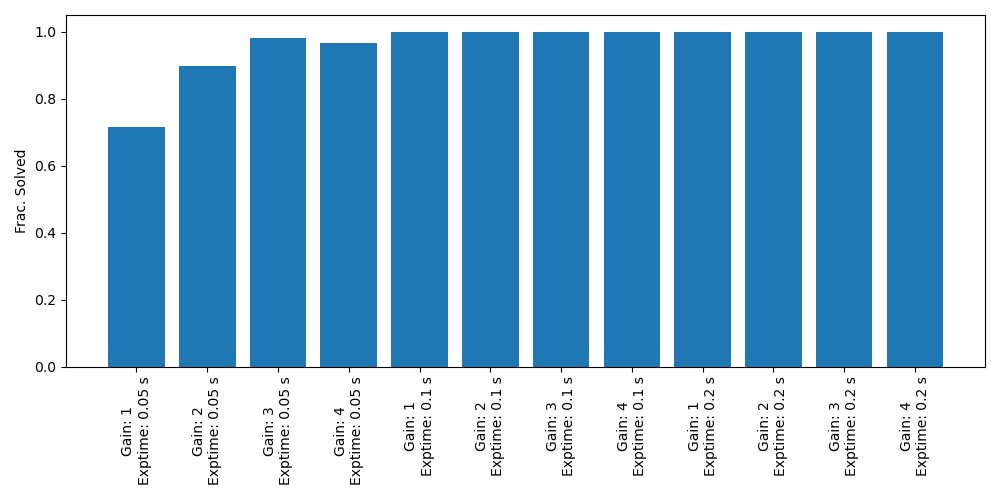

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

float_time = datetime.datetime.fromisoformat('2025-10-01T19:00:00.0000Z').timestamp() * u.s

tol = 1e-3
i = 0
labels = []
for exptime in np.array([0.05, 0.1, 0.2]) * u.s:
    for gain in range(1,5):
        pop = (
            (img_table_solved['TIMESTAMP'] > float_time) &
            (abs(img_table_solved['GAINFACT'] - gain) < tol) &
            (abs(img_table_solved['EXPTIME'] - exptime) < (tol * exptime.unit))
        )
        print(gain, exptime, img_table_solved['GAINFACT'][pop], img_table_solved['EXPTIME'][pop])
        ax.bar(i, np.nansum(img_table_solved['SOLVED'][pop]) / np.nansum(img_table_solved['SOLVE_ATTEMPTED'][pop]), color='C0')
        i += 1
        labels.append(f'Gain: {gain}\nExptime: {exptime}')
ax.set_ylabel('Frac. Solved')
ax.set_xticks(range(i))
ax.set_xticklabels(labels, rotation=90)
fig.tight_layout()

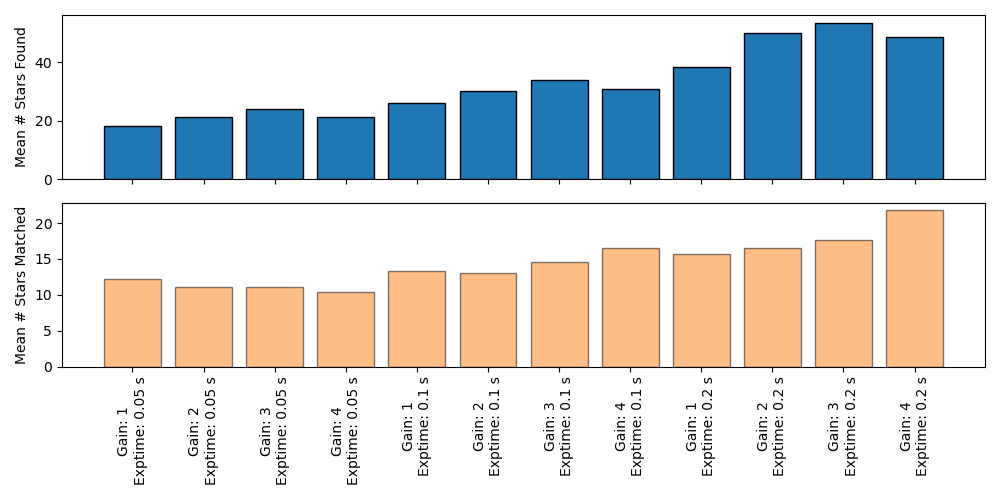

In [12]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)

tol = 1e-3
i = 0
labels = []
for exptime in np.array([0.05, 0.1, 0.2]) * u.s:
    for gain in range(1,5):
        pop = (
            (img_table_solved['TIMESTAMP'] > float_time) &
            (abs(img_table_solved['GAINFACT'] - gain) < tol) &
            (abs(img_table_solved['EXPTIME'] - exptime) < (tol * exptime.unit))
        )
        # print(gain, exptime, img_table_solved['GAINFACT'][pop], img_table_solved['EXPTIME'][pop])
        ax[0].bar(i, np.nanmean(img_table_solved['N_STARS_FOUND'][pop]), edgecolor='k', facecolor='C0')
        ax[1].bar(i, np.nanmean(img_table_solved['N_STARS_MATCHED'][pop]), edgecolor='k', facecolor='C1', alpha=0.5)
        i += 1
        labels.append(f'Gain: {gain}\nExptime: {exptime}')
ax[0].set_ylabel('Mean # Stars Found')
ax[1].set_ylabel('Mean # Stars Matched')
ax[1].set_xticks(range(i))
ax[1].set_xticklabels(labels, rotation=90)
fig.tight_layout()

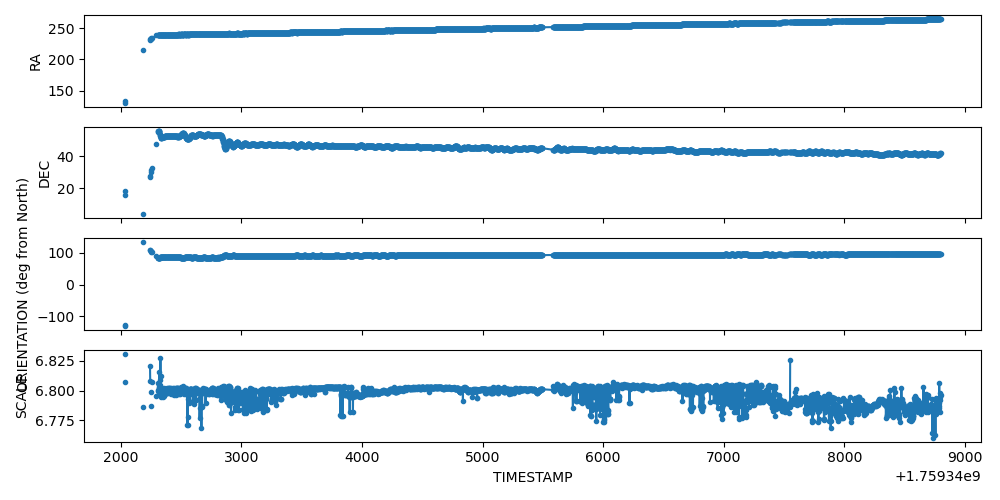

In [13]:
fig, ax = plt.subplots(figsize=(10,5), nrows=4, sharex=True)
ax[0].plot(img_table_solved['TIMESTAMP'], img_table_solved['RA'], marker='.')
# ax[0].set_xlabel('TIMESTAMP')
ax[0].set_ylabel('RA')

ax[1].plot(img_table_solved['TIMESTAMP'], img_table_solved['DEC'], marker='.')
# ax[1].set_xlabel('TIMESTAMP')
ax[1].set_ylabel('DEC')

ax[2].plot(img_table_solved['TIMESTAMP'], img_table_solved['ORIENTATION'], marker='.')
# ax[2].set_xlabel('TIMESTAMP')
ax[2].set_ylabel('ORIENTATION (deg from North)')

ax[3].plot(img_table_solved['TIMESTAMP'], img_table_solved['SCALE'], marker='.')
ax[3].set_xlabel('TIMESTAMP')
ax[3].set_ylabel('SCALE')

fig.tight_layout()

In [14]:
img_table_solved['DEC']

<Quantity [        nan,         nan,         nan, ..., 41.93049848,
                   nan,         nan] deg>

Text(0, 0.5, 'DEC')

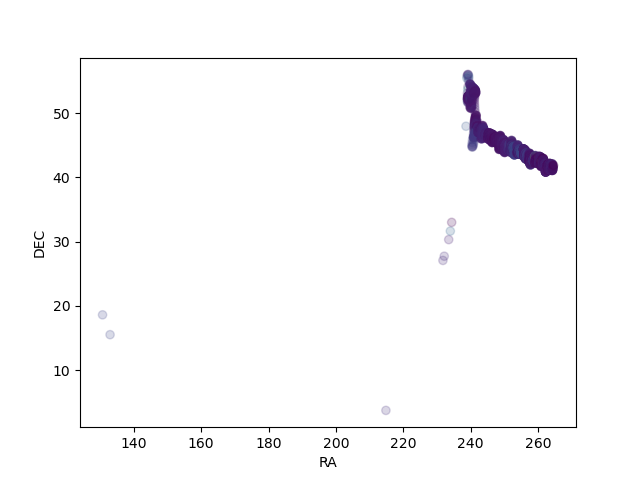

In [15]:
fig, ax = plt.subplots()
ax.scatter(img_table_solved['RA'], img_table_solved['DEC'], c=img_table_solved['RMSE'].value, alpha=0.2)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

Text(0, 0.5, 'RMSE')

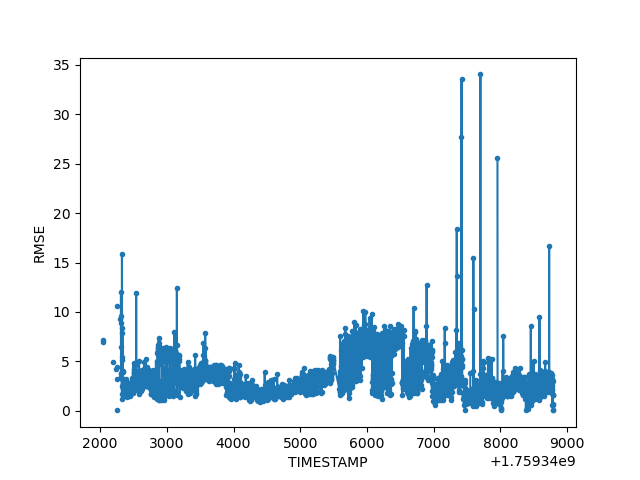

In [16]:
fig, ax = plt.subplots()
ax.plot(img_table_solved['TIMESTAMP'], img_table_solved['RMSE'], marker='.')
ax.set_xlabel('TIMESTAMP')
ax.set_ylabel('RMSE')

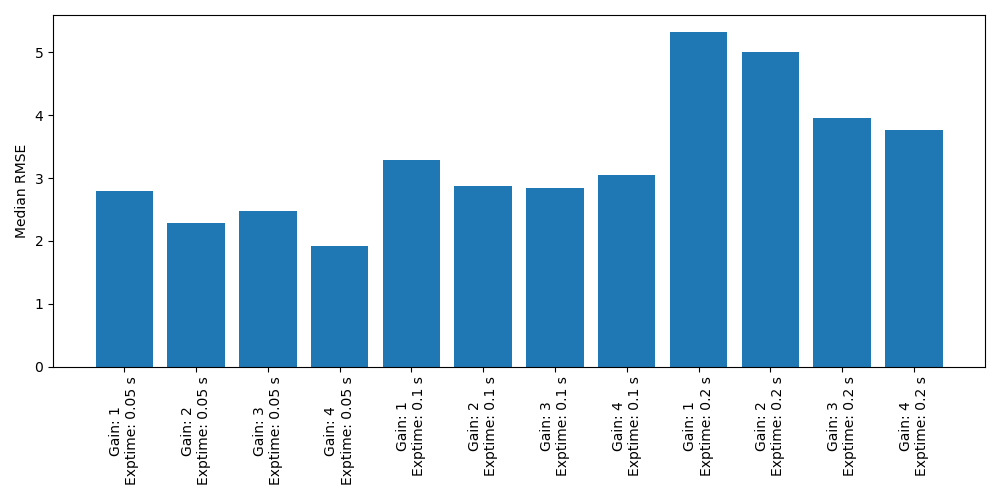

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

tol = 1e-3
i = 0
labels = []
for exptime in np.array([0.05, 0.1, 0.2]) * u.s:
    for gain in range(1,5):
        pop = (
            (img_table_solved['TIMESTAMP'] > float_time) &
            (abs(img_table_solved['GAINFACT'] - gain) < tol) &
            (abs(img_table_solved['EXPTIME'] - exptime) < (tol * exptime.unit))
        )
        ax.bar(i, np.nanmedian(img_table_solved['RMSE'][pop]), color='C0')
        i += 1
        labels.append(f'Gain: {gain}\nExptime: {exptime}')
ax.set_ylabel('Median RMSE')
ax.set_xticks(range(i))
ax.set_xticklabels(labels, rotation=90)
fig.tight_layout()

Text(0, 0.5, 'RMSE')

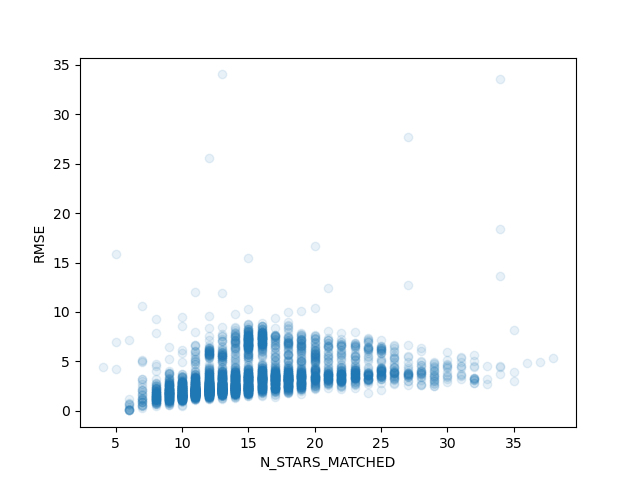

In [18]:
fig, ax = plt.subplots()
ax.scatter(img_table_solved['N_STARS_MATCHED'], img_table_solved['RMSE'], alpha=0.1)
ax.set_xlabel('N_STARS_MATCHED')
ax.set_ylabel('RMSE')

Text(0, 0.5, 'RMSE')

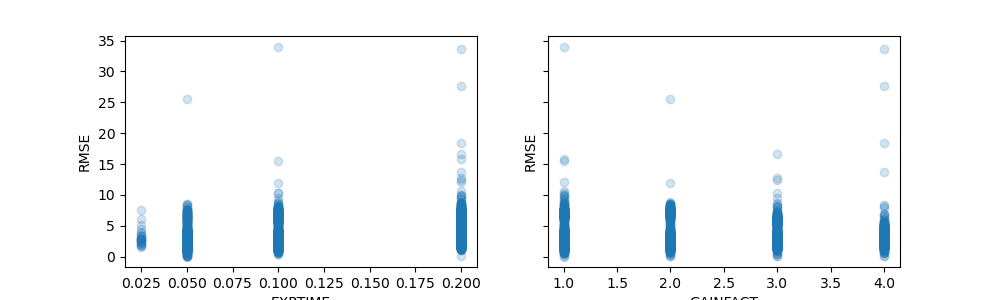

In [19]:
fig, axs = plt.subplots(figsize=(10,3), ncols=2, sharey=True)
ax = axs[0]
ax.scatter(img_table_solved['EXPTIME'], img_table_solved['RMSE'], alpha=0.2)
ax.set_xlabel('EXPTIME')
ax.set_ylabel('RMSE')

ax = axs[1]
ax.scatter(img_table_solved['GAINFACT'], img_table_solved['RMSE'], alpha=0.2)
ax.set_xlabel('GAINFACT')
ax.set_ylabel('RMSE')

In [20]:
pct_float_solved = 100 * np.nansum(img_table_solved['SOLVED'][(img_table_solved['TIMESTAMP'] > float_time)]) / np.nansum(img_table_solved['SOLVE_ATTEMPTED'][(img_table_solved['TIMESTAMP'] > float_time)])